$$
\newcommand{P}[1]{\mathrm{P}\left( #1 \right)}
\newcommand{Pc}[2]{\mathrm{P}\left( #1 \mid #2 \right)}
\newcommand{In}[2]{ #1 \perp\!\!\!\perp #2}
\newcommand{Cin}[3]{ #1 \perp\!\!\!\perp #2 \, | \, #3}
\newcommand{do}[1]{\mathrm{do}\left( #1 \right)}
$$

In a [previous blog post](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/) I discussed how we can use the idea of [potential outcomes](https://en.wikipedia.org/wiki/Rubin_causal_model) to make causal inferences from observational data. Under the Potential Outcomes framework we treat the counterfactual outcome as if it were [missing data](https://en.wikipedia.org/wiki/Missing_data) and attempt to estimate these missing values from the observed data. To do this we needed to make strong assumptions about the data generating process, specifically "Strong Ignorability"

$\Cin{Y_{i}}{X}{Z}$

Where $Y_{i}$ are the potential outcomes we are trying to estimate, $X$ is the intervention we are trying to measure and $Z$ are a set of covariates which allow us to "correct" our estimate. This statement should be read: "$Y_{i}$ is conditional independent of $X$ given $Z$".

This is a strong statement about the process which generated our data. In order to understand where strong ignorability hold, we need to make some assumptions about the _structure_ of the data generating process itself. The language we will be using to express this structure is that of Causal Graphical Models. In this post I will try to give an light overview of causal graphical model using a [python package of the same name](https://github.com/ijmbarr/causalgraphicalmodels). 

Compared to my previous post, this post will be less about techniques to make causal inferences and more on gaining intuition about how we can describe data generating structure and what statements we can make once we have such a description. I am also not going to be playing fast and loose with some of the maths 

# What is Structure? 

One way we can try and model the world is through the idea of Structural Causal Models, or [Structural Equation Models](https://en.wikipedia.org/wiki/Structural_equation_modeling): that we can model the relationships between different variables is described by functions. 

For example, imagine a system of three variables, $x_{1}, x_{2}, x_{3}$. We could imagine they are related in the following way:

$x_{1} \sim \hbox{Bernoulli}(0.3)$

$x_{2} \sim \hbox{Normal}(x_{1}, 0.1)$

$x_{3} = x_{3}^{2}$

$X_{1}$ and $X_{2}$ are samples from random variables, and $X_{3}$ is a deterministic function of $X_{2}$. 

It is easy to simulate this system in python:

In [1]:
# first, import some standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def f1(): 
    return np.random.binomial(n=1,p=0.3)

def f2(x1):
    return np.random.normal(loc=x1, scale=0.1)
    
def f3(x2):
    return x2 ** 2

x1 = f1()
x2 = f2(x1)
x3 = f3(x2)

print("x1 = {}, x2 = {:.2f}, x3 = {:.2f}".format(x1, x2, x3))

x1 = 0, x2 = -0.04, x3 = 0.00


Structure is the description of which variables are functions of which other variables. In the above example, `x1` can only influence `x3` _though_ `x2`, no matter what the actual functions are. 

This way of modeling structure is appealing because it has a natural way to describe interventions: we reach into the system and replace the value of one variable with one we choose. If we replace `x2` with some value `x2_intervention` the system would now be updated according to

```python
x1 = f1()
x2 = x2_intervention
x3 = f3(x2)
```

This has the very measurable consequence that if we intervene on `x2`, `x3` will be independent of `x1`. This wouldn't be the case if the structure had looked something like

```python
x1 = f1()
x2 = f2(x1)
x3 = f3(x2, x1)
```

Here there is no ambiguity about what intervention means, and what the structure of the system is. It might seem too far fetched to assume that _all_ relationships been things we measure can be described this way, but ultimately the justification is the universe is governed by the laws of physics. These functions might be very complicated, stochastic, or unknown, but they exist. 

The question then becomes: what can we say about interventions when we don't know the true functional relationships, only the structure. 

Note: This isn't _entirely_ true. Quantum mechanics has some interesting things to say about causality, and if I get the chance, I'll try and write about them. For most causal inference tasks, we can safely ignore quantum effects.

## Causal Graphical Models

Let us begin with a classical example of a causal system: the sprinker. It is a system of five variable which indicate the conditions on a certain day:

 - $season$: indicates which season it is
 - $rain$: indicates whether it is raining
 - $sprinkler$: indicates whether our sprinkler is on
 - $wet$: indicates whether the group is wet
 - $slippery$: indicates whether the ground is slippery
 
We know that when it rains, the ground will become wet, however the making the ground wet doesn't cause it to rain. This is exactly the kind of direct relationship that could be described by a function. In the absence of this actual function, we are left with a set of variables and directed relationships between then. A natural way to represent this structure is a directed graph, specifically a [Directed Acyclic Graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph). We require the graph to be acyclic to prevent "causal loops".

We can create a causal graphical model of this system by specifying the nodes and edges of this graph:

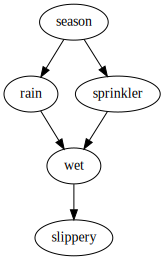

In [3]:
from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

This is a [Probabilistic Graphical Model](https://en.wikipedia.org/wiki/Graphical_model) description of the system (for more information, I recommend this excellent [Coursera Course](https://www.coursera.org/learn/probabilistic-graphical-models) on probabilistic graphical models): a non-parametric model of the structure which generates data.

Describing a system in the way implies that the joint probability distribution over all variables can be factored in the following way:

$\P{\mathbf{X}} = \prod_{i}\Pc{X_{i}}{\hbox{PA}(X_{i})}$

Where $\hbox{PA}(X_{i})$ is the set of parents of the variable $X_{i}$, with respect to the graph.

We can get the join probability distribution implied by our causal graphical model using

In [4]:
print(sprinkler.get_distribution())

P(season)P(sprinkler|season)P(rain|season)P(wet|rain,sprinkler)P(slippery|wet)


This factorization of the joint probability distribution in implies certain [conditional independence](https://en.wikipedia.org/wiki/Conditional_independence) relationships between variables. For example, if we know whether or not the ground is wet, then whether or not it is slippery is independent of the season. In the language of probabilistic graphical models, two variables are conditionally independent given other variables if they are [d-separated](https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html).

I'm not going to go into a full proof of d-separation, but to get some intuition about how it is calculated, consider the skeleton of our DAG (the graph with the same nodes and edges, but no notion of "direction"). Two variables can only be related if there are paths between them, so we can limit our attention to the paths between variables. If there is only a single edge between the variables, they cannot be conditionally independent. 

For paths of three nodes, there are three possible situations, a fork, a chain and a collider, shown below:

Implied conditional Independence Relationship:  [('x1', 'x3', {'x2'})]


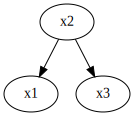

In [5]:
from causalgraphicalmodels.examples import fork, chain, collider

print("Implied conditional Independence Relationship: ", 
      fork.get_all_independence_relationships())
fork.draw()

Implied conditional Independence Relationship:  [('x1', 'x3', {'x2'})]


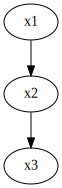

In [6]:
print("Implied conditional Independence Relationship: ", 
      chain.get_all_independence_relationships())
chain.draw()

In the fork and the chain imply the same independence relationships: $X_{1}$ and $X_{3}$ are not independent, unless we condition on $X_{2}$ when they become conditionally independent. (Although I should note they imply very different causal structures: In a chain $X_{1}$ has causal influence on $X_{3}$, but in a fork there is no causal influence).

Implied conditional Independence Relationship:  [('x1', 'x3', set())]


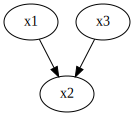

In [7]:
print("Implied conditional Independence Relationship: ", 
      collider.get_all_independence_relationships())
collider.draw()

For the collider, $x_{1}$ and $x_{3}$ are independent, unless $x_{2}$ or any of it's descendants are in the group we condition on. This is sometimes called [Berkson's Paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox). 

For paths longer then length 3, it turns out we can use the previous results to decide if two nodes are d-separated by examining each three structure along the paths: a path is d-separated if all sets of consecutive 3-nodes are d-separated. 

Consider the following path between $X_{1}$ and $X_{5}$:

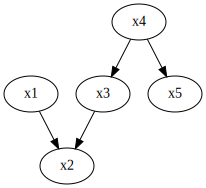

In [8]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3", "x4", "x5"],
    edges = [("x1", "x2"), ("x3", "x2"), ("x4", "x3"), ("x4", "x5")]
)

path.draw()

If we condition on nothing, they are d-separated because the collider ($X_{1}$, $X_{2}$, $X_{3}$) leaves the path blocked. However, if we condition on $X_{2}$ or any of it's descendants the path becomes unblocked, because the rest of the path is made up of forks ($X_{3}$, $X_{4}$, $X_{5}$) and chains ($X_{2}$, $X_{3}$, $X_{4}$). If we condition on $X_{2}$ _and_ $X_{3}$ the path becomes blocked again because the chain ($X_{2}$, $X_{3}$, $X_{4}$) is blocked.

We can check this with the following code:

In [9]:
print("Are x1 and x5 unconditional independent? {} "
      .format(path.is_d_separated("x1", "x5", {})))

print("Are x1 and x5 conditional independent when conditioning on x2? {} "
      .format(path.is_d_separated("x1", "x5", {"x2"})))

print("Are x1 and x5 conditional independent when conditioning on x2 and x3? {} "
      .format(path.is_d_separated("x1", "x5", {"x2", "x3"})))

Are x1 and x5 unconditional independent? True 
Are x1 and x5 conditional independent when conditioning on x2? False 
Are x1 and x5 conditional independent when conditioning on x2 and x3? True 


We can read off all independence relationships implied by the graph in the sprinkler system using:

In [10]:
sprinkler.get_all_independence_relationships()

[('slippery', 'rain', {'wet'}),
 ('slippery', 'rain', {'sprinkler', 'wet'}),
 ('slippery', 'rain', {'season', 'wet'}),
 ('slippery', 'rain', {'season', 'sprinkler', 'wet'}),
 ('slippery', 'season', {'wet'}),
 ('slippery', 'season', {'sprinkler', 'wet'}),
 ('slippery', 'season', {'rain', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler'}),
 ('slippery', 'season', {'rain', 'sprinkler', 'wet'}),
 ('slippery', 'sprinkler', {'wet'}),
 ('slippery', 'sprinkler', {'season', 'wet'}),
 ('slippery', 'sprinkler', {'rain', 'wet'}),
 ('slippery', 'sprinkler', {'rain', 'season', 'wet'}),
 ('rain', 'sprinkler', {'season'}),
 ('season', 'wet', {'rain', 'sprinkler'}),
 ('season', 'wet', {'rain', 'slippery', 'sprinkler'})]

At this point it is worth emphasising that causal graphical models are _non-parametric_: they do not make any assumptions about the functional form of relationships between variables, only that they exist. Because of this the only testable assumption these models make are the conditional independence relationships between the variables. Unfortunately, [testing conditional independence, in the general case, is impossible](https://arxiv.org/pdf/1804.07203.pdf). Combined with the fact that there are [many possible DAGs](http://arantxa.ii.uam.es/~ssantini/writing/notes/s649_dag_counting.pdf) for even a reasonable number of variables, discovering causal structure from observational data alone is very difficult. 

There are still some [interesting approaches](https://arxiv.org/abs/1501.01332) to identifying causal structure, but for these notes, it is best to think of the main use of causal graphical models as a way of explicitly encoding prior knowledge about the structure of a system, and to use this structure combined with observational data to make predictions about the effect of causal interventions.

# From Bayesian networks to Causal Graphical Models

So far, our description of causal graphical models has been the same as those of general [Bayesian Networks](https://en.wikipedia.org/wiki/Bayesian_network). To endow these structures with a notion of causality, we some assumptions about what happens when an intervention occurs. In causal graphical models, this is the notion of "**Stability**" or "**Invariance**" - that when we make an intervention on one variable, the structure of the causal graph and the functional relationships between the remaining variables remain the same.

If the assumption of invariance holds, the effect of an intervention on variable $X$ to remove the edges between the variable and it's parents. We typically denote a node with an intervention with a node with a double outline. 

Imagine that we had the power the control the weather. If use it to make an intervention on the "rain" node of our sprinkler model, we get the following system:

P(season)P(sprinkler|season)P(wet|do(rain),sprinkler)P(slippery|wet)


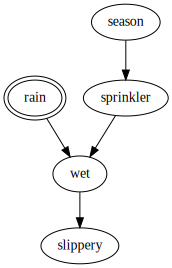

In [11]:
sprinkler_do = sprinkler.do("rain")

print(sprinkler_do.get_distribution())

sprinkler_do.draw()

Because causal graphical models are non-parametric, they cannot tell us _what_ the relationship between two variables are, they only give us an idea _if_ there is a relationship between the two variables through the notion of conditional independence. It does this using the idea of "paths" between variables: if there are no unblocked paths between two variables, they are independent. It also means that if two causal graphical models share the same paths between two variables, the conditional relationship between these two variables are the same. 

For example, in the graph of out sprinkler system, $\Pc{slippery}{wet}$ is the same whether or not we make an intervention on $rain$, but $\Pc{slippery}{season}$ is not.

Describing the interventions in the way has some immediate consequences:

- $X$ can only have some causal inference on $Y$ if there is at least one directed path between $X$ and $Y$. This is because if there is no directed path, with respect to the interventional graph the parents of $X$ have been removed, so $\In{X}{Y}$ in the intervential graph.
- If there are _only_ directed paths between $X$ and $Y$, then the the causal influence of $X$ on $Y$ is given by the simply by the conditional distribution $\Pc{Y}{X}$. This is because the interventional graph has the same paths between $X$ and $Y$ as the observational distribution.
- If there is a unblocked, but not completely directed path between $X$ and $Y$, it means that both $X$ and $Y$ share a common ancestor. This common ancestor is what is called a [_confounder_](https://en.wikipedia.org/wiki/Confounding), and will mean that if we try to estimate $\Pc{Y}{\do{X}}$ from $\Pc{Y}{X}$ of estimates will be biased.
 
None of these results should be too surprising, but causal graphical models give us a way to quantify these understanding.

# Causal Inference with  Causal Graphical Models

Now that we have a way of describing how both observational and interventional distributions are generated and how they relate to each other, we can ask under what circumstances it is possible to make causal inferences from a system we only have observational samples from. This problem is often called "Identifiability". 

To be specific, the question is under what circumstances can we estimate

$\Pc{Y}{\do{X}}$

from observational data, given some assumed causal graphical model?

It turns out we can do this via a set of manipulations known as [do-calculus](https://arxiv.org/pdf/1210.4852.pdf), a set of rules which together with the standard [rules of manipulating probability distributions](https://arxiv.org/pdf/1205.4446.pdf) can allow expressions involving distributions conditioned by $\do{\dots}$ to be transformed into a form which involves no interventions. 

I'm not going to cover the full score of do-calculus here, instead I'm going to explore some examples. 

Let's start with the following causal graphical model:

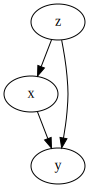

In [12]:
from causalgraphicalmodels.examples import simple_confounded

simple_confounded.draw()

Under intervention on $X$, the causal graphical model generating the data is 

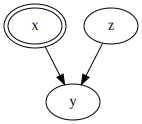

In [13]:
simple_confounded.do("x").draw()

We are going to try and estimate the quantity

$\Pc{Y}{\do{X}}$

We can start by expanding this distribution using the standard rules of marginalization: 

$\Pc{Y}{\do{X}} = \sum_{Z} \Pc{Y}{\do{X}, Z} \Pc{Z}{\do{X}}$

And because in the interventional distribution $\do{X}$ is independent of $Z$ we get 

$\Pc{Y}{\do{X}} = \sum_{Z} \Pc{Y}{\do{X}, Z} \P{Z}$

Appealing to the assumption of stability, we assume that the conditional distribution of $Y$ given it's parents is takes the same form when an intervention takes place, we can write:

$\Pc{Y}{\do{X}} = \sum_{Z} \Pc{Y}{X, Z} \P{Z}$

Where there are no more references to $\do{\dots}$ on the right hand side of the equation: we succeeded writing an interventional distribution in terms of a observational distribution. It is worth comparing this with a similar formula for the observational conditional distribution:

$\Pc{Y}{X} = \sum_{Z} \Pc{Y}{X, Z} \Pc{Z}{X}$


# When can we use the Adjustment Formula?

The formula we found in the previous section appears in a number of areas, and is something called the adjustment formula, or g-formula or backdoor adjustment formula. It states that under certain circumstances, for a set of variables $W$, we can estimate the the causal influence of $X$ on $Y$ with respect to a causal graphical model using the equation

$\Pc{Y}{\do{X}} = \sum_{W} \Pc{Y}{X, W} \P{W}$

The criterion for $W$ to exist is sometimes called the backdoor criterion. Graphically it states that

1. $W$ blocks all backdoor paths between $X$ and $Y$ (all paths with arrows going into $X$)
2. $W$ does not contain any descendants of $X$

Like in the previous section, these criteria are met when $W$ are the parents of $X$, but these aren't the only variables which can be used as an adjustment set. Consider the following graph: 

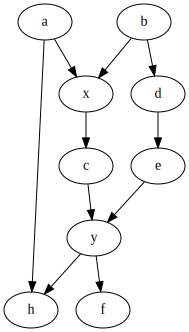

In [14]:
from causalgraphicalmodels.examples import big_csm

example_cgm = big_csm.cgm
example_cgm.draw()

There are two backdoor paths between $X$ and $Y$:

In [15]:
example_cgm.get_all_backdoor_paths("x", "y")

[['x', 'a', 'h', 'y'], ['x', 'b', 'd', 'e', 'y']]

But because $h$ acts as a collider in the first path, it is blocked unless conditioned on. To find a valid adjustment set, we need a set which blocks this path. Any of the variables $B$, $D$, $E$ would work, as well as any combination of the above. We can also include any other variable in this set, as long as it doesn't create new paths. Adding $H$, $F$ or $C$ to the adjustment set would create a new path, making the adjustment set invalid: 

In [16]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e"})

True

In [17]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e", "h"})

False

We can compute all valid adjustment sets using the following:

In [18]:
example_cgm.get_all_backdoor_adjustment_sets("x", "y")

frozenset({frozenset({'a', 'd', 'e'}),
           frozenset({'b', 'd'}),
           frozenset({'a', 'e'}),
           frozenset({'a', 'b'}),
           frozenset({'a', 'b', 'e'}),
           frozenset({'d'}),
           frozenset({'e'}),
           frozenset({'d', 'e'}),
           frozenset({'a', 'd'}),
           frozenset({'b'}),
           frozenset({'a', 'b', 'd'}),
           frozenset({'b', 'e'}),
           frozenset({'b', 'd', 'e'}),
           frozenset({'a', 'b', 'd', 'e'})})

For a full proof of the backdoor criteria, I suggest chapter 6 of the excellent book [Elements of Causal Inference](https://mitpress.mit.edu/books/elements-causal-inference), but some intuition about these requirements is that blocking all backdoor path accounts for any bias introduced by confounding variables, and the requirement that no descendants are conditioned on prevents any _new_ paths from being created.

When all variables in a causal graphical model are observed, is alway a set which can be used for adjustment. If not all variables are observed, there can be causal statements which cannot be estimated from the observed data.

# Relationship with Potential Outcomes

Given the focus on potential outcomes that my previous post had, it is worth asking what the relationship between causal graphical models and them is. It turns out that the two approaches are exactly equivalent to each other, and a statement in one can be related to a statement in the other. 

There is a slight subtle point that so far I've treated causal graphical models as a way to make statements about _causal inference_ (how data would be generated if there is an intervention on the system), whereas potential outcomes describe _counterfactual inference_ (what would have happened to a system which had already been observed, if a different treatment had been applied), but it is possible to use CGMs/SCMs to reason about counterfactuals, although it is beyond these notes.

That said, one of the main benefits of explicitly drawing out a causal graphical model of your system is that it makes clear whether or not conditional independence statements like

$\Cin{Y_{i}}{X}{Z}$

are valid. 

To see how statements like this fit into CGMs, we need to start by expanding our system to include the potential outcomes:

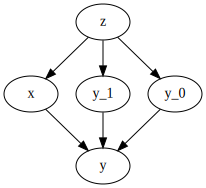

In [19]:
from causalgraphicalmodels.examples import simple_confounded_potential_outcomes

simple_confounded_potential_outcomes.draw()

Here $Y_{i}$ is the potential outcome for $X=i$, and the node $Y$ now the deterministic function $Y(X, Y_{1}, Y_{0}) = Y_{X}$.

By examination, it should be clear that $\Cin{Y_{i}}{X}{Z}$ holds. 

Looking at the graph, we see that by construction there are no direct paths from $X$ to the potential outcomes $Y_{i}$, only backdoor paths. This means the conditional independence statement holds as long as the set $Z$ blocks all backdoor paths between $Y$ and $X$, and does not create any new one. This is exactly the backdoor criteria.  

# Actually Estimating Causal Effects 

In our example of the `simple_confounding` causal graphical model, we showed that to make estimates of $\Pc{Y}{\do{X}}$ we need a way of estimating the quantity $\Pc{Y}{X, Z}$ from our observational data. 

Causal graphical models don't offer a way of doing this. They are a tool for answering question about _if_ we can make causal inferences, given an assumed structure, and how we would do this _if_ we can estimate statistical quantities like $\Pc{Y}{X, Z}$. However, there are a number of statistical techniques we can use to make this estimate. For example, my previous most covered a number of ways to estimate the quantity $E[Y|X,Z]$ from potentially biased observations, which is often what we care about instead of the full distribution.

# Example Use Case

We've been though a lot to reach this point, so it is good to reflect on how we can actually use causal graphical models to do something useful.

Let's take another look at the following structural causal model:

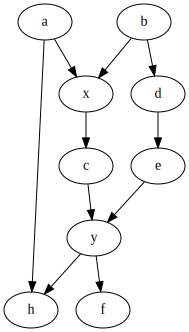

In [20]:
big_csm.cgm.draw()

The [structure](https://github.com/ijmbarr/causalgraphicalmodels/blob/20e0ca1de90ccb0c4a569d9a92a0215d4e57cb3a/causalgraphicalmodels/examples.py#L56) in this model are just linear relationships between variables with Gaussian noise, with the exception of $X$, which is Bernoulli distributed. The whole thing is encapsulated in a `StructuralCausalModel` object which makes it easy to sample observational data from:

In [21]:
big_csm.sample(5)

,a,b,c,d,e,f,h,x,y
0,0.696485,0.849004,0.512328,-1.877430,-2.981484,3.024886,6.432555,0,4.690296
1,-0.960686,-2.621972,1.094445,3.105839,7.202387,-3.319097,-8.013940,0,-4.438694
2,-1.240862,0.825594,1.555216,-0.872669,-3.293294,4.543829,7.927069,1,7.820964
3,-1.794861,-0.960123,0.257391,0.759459,1.073854,-3.124381,-6.344803,0,-2.290865
4,0.458812,-1.653600,0.474086,2.501353,4.918685,-2.474993,-3.763032,0,-5.151883


Our goal will be to estimate the Average Treatment Effect of $X$ on $Y$. I will be using the ['causalinference'](https://github.com/laurencium/Causalinference) package to do this. The main question is which covariants should we use to adjust?

Let's start by defining a function which calculates the ATE given variable adjustment sets:

In [22]:
from causalinference import CausalModel

def estimate_ate(dataset, adjustment_set=None, method="matching"):
    """
    Estimate the ATE of X on Y from from dataset when 
    adjusting using adjustment_set.
    
    Arguments
    ---------
    dataset: pd.DateFrame
        dataframe of observations
        
    adjustment_set: iterable of variables or None
    
    method: str
        adjustment method to use.    
    """
    
    if adjustment_set is None:
        y0 = dataset.loc[lambda df: df.x == 0].y.mean()
        y1 = dataset.loc[lambda df: df.x == 1].y.mean()
        
        y0_var = dataset.loc[lambda df: df.x == 0].y.var()
        y1_var = dataset.loc[lambda df: df.x == 1].y.var()
        
        y0_n = dataset.loc[lambda df: df.x == 0].shape[0]
        y1_n = dataset.loc[lambda df: df.x == 1].shape[0]
        
        return {
            "ate": y1 - y0,
            "ate_se": 2 * np.sqrt(y0_var/y0_n + y1_var/y1_n)
        }

    cm = CausalModel(
        Y=dataset.y.values, 
        D=dataset.x.values, 
        X=dataset[adjustment_set].values
    )

    cm.est_via_ols()
    cm.est_via_matching()
    cm.est_propensity_s()
    cm.est_via_weighting()

    cm.stratify_s()
    cm.est_via_blocking()
    
    results = {
        "ate": cm.estimates[method]["ate"],
        "ate_se": cm.estimates[method]["ate_se"]
    }

    return results

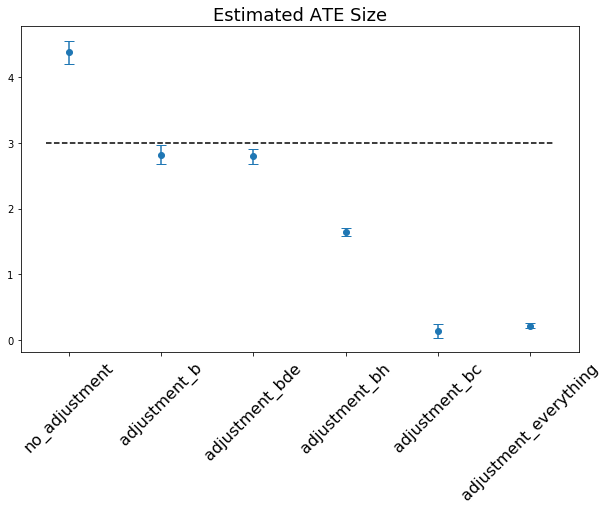

In [23]:
n_samples = 10000

ds = big_csm.sample(n_samples)

# this allows us to generate samples from an interventional distribution
# where the value of X is assigned randomly as in an A/B test.
ds_intervention = (
    big_csm
    .do("x")
    .sample(
        n_samples=1000000, 
        set_values={"x": np.random.binomial(p=0.5, n=1, size=1000000)})
)

true_ate = estimate_ate(ds_intervention)["ate"]

# generate results for a number of different adjustment sets
results = {
    "no_adjustment": estimate_ate(ds),
    "adjustment_b": estimate_ate(ds, ["b"]),
    "adjustment_bde": estimate_ate(ds, ["b", "d", "e"]),
    "adjustment_bh": estimate_ate(ds, ["b", "h"]),
    "adjustment_bc": estimate_ate(ds, ["b", "c"]),
    "adjustment_everything": estimate_ate(ds, ["a", "b", "c", "d", "e", "f", "h"]),

}

# plot the results
x_label = list(results.keys())
x = np.arange(len(x_label))
y = [results[l]["ate"] for l in x_label]
yerr = [results[l]["ate_se"] for l in x_label]

plt.figure(figsize=(10,6))
plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
plt.xticks(x, x_label, rotation=45, fontsize=16)
plt.title("Estimated ATE Size", fontsize=18)
xmin, xmax = plt.xlim()
plt.hlines(true_ate, xmin, xmax, linestyles="dashed")


We can see that when we use the valid adjustment sets we get close to the true value, but excluding or including extra variables can make things worse. This is hopefully a warning about why it is not a good idea to use _all_ the features you have to correct for observational bias - you should always considering the structure that generated the data. Causal Graphical Models are an excellent way to do this.

# Conclusions

Hopefully these notes have been a useful introduction Causal Graphical Models. There is still a lot that I haven't had a change to cover. Very loosely, work with them can be categorised in two area:

 - **Identification**: Given assumptions about the causal structure of a system, can we estimate influence of one variable on another.
 - **Discovery**: Given data, how can we estimate the causal structure of a system.
 
The backdoor adjustment method is one example of identification discussed in these notes - it is not the only one. In my [next post](http://www.degeneratestate.org/posts/2018/Sep/03/causal-inference-with-python-part-3-frontdoor-adjustment/) I will look at how we can use mediating variables to make causal inferences. More generally, [it has been shown](https://www.aaai.org/Papers/AAAI/2006/AAAI06-191.pdf) that for partly observed causal graphical models it is possible to decide exactly whether or not a causal statement is identifiable and the rules of do-calculus are complete. 

In the other direction, learning causal structure is much more difficult. There are [some tools](http://www.phil.cmu.edu/tetrad/) out there to estimate structure, but in my experience, when guided only by the data they tend to produce nonsensical results. I suspect this is because given only limited observational data there often is not enough information to accurately estimate structure. There is some [interested work](https://arxiv.org/abs/1501.01332) on how to use combinations of observational data from different setting to try and infer structure, but I think in general this is an open problem.

I hope to have a chance to discuss more of these areas in future posts.

# Code

You can find the notebook for this post on github [here](https://github.com/ijmbarr/notes-on-causal-inference).